In [30]:
import json
import pandas as pd

# Open and read the JSON file
with open('/Users/saadinurazisbekuulu/Downloads/ShtukaResearch/lpt-data/lpt-data.json', 'r') as file:
    data = json.load(file)

# Now `data` is a Python dictionary (or list, depending on the JSON structure)
data = pd.DataFrame(data)
print(data['bonded']/data['total-supply']) #
print(data['inflation']/1e9 * data['total-supply']) # new minted tokens
print(data['inflation']/1e9 * 365)

dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
data['date'] = dates
print(data)

0      0.415313
1      0.415221
2      0.415449
3      0.415863
4      0.416186
         ...   
361    0.401915
362    0.402174
363    0.402615
364     0.40276
365    0.400638
Length: 366, dtype: object
0      11710780152979067502592.0
1      11730350469185366130688.0
2      11769595947622657425408.0
3      11789272941942297067520.0
4      11808918574676507099136.0
                 ...            
361    21720490683418395279360.0
362    21751725446655201247232.0
363    21782957744122807451648.0
364    21814228276331952472064.0
365    21876826863486879399936.0
Length: 366, dtype: object
0      0.141255
1      0.141437
2      0.141802
3      0.141985
4      0.142168
         ...   
361    0.215167
362    0.215350
363    0.215532
364    0.215715
365    0.216080
Name: inflation, Length: 366, dtype: float64
     inflation                total-supply                      bonded  \
0       387000  30260413831987256828836706  12567535604355922512661056   
1       387500  3027187217854288095451

In [25]:
import requests
import pandas as pd
from datetime import datetime
import time

# --- CONFIG ---
COINGECKO_API = "https://api.coingecko.com/api/v3/coins/{}/market_chart"
COINS = {
    'livepeer': 'LPT',
    'bitcoin': 'BTC',
    'ethereum': 'ETH'
}

# --- FUNCTIONS ---
def fetch_coingecko_price_and_volume(coin_id, days="365", vs_currency="usd"):
    """Fetch daily price and volume from Coingecko."""
    url = COINGECKO_API.format(coin_id)
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    r = requests.get(url, params=params)
    data = r.json()
    prices = data.get('prices', [])
    volumes = data.get('total_volumes', [])

    df_price = pd.DataFrame(prices, columns=['timestamp', f'{coin_id}_price'])
    df_volume = pd.DataFrame(volumes, columns=['timestamp', f'{coin_id}_volume'])
    df_price['date'] = pd.to_datetime(df_price['timestamp'], unit='ms').dt.date
    df_volume['date'] = pd.to_datetime(df_volume['timestamp'], unit='ms').dt.date

    df = pd.merge(df_price[['date', f'{coin_id}_price']],
                  df_volume[['date', f'{coin_id}_volume']], on='date')
    return df

# --- MAIN ---
df_all = None

for coin_id, symbol in COINS.items():
    print(f"Fetching data for {symbol}...")
    df = fetch_coingecko_price_and_volume(coin_id)
    if df_all is None:
        df_all = df
    else:
        df_all = pd.merge(df_all, df, on='date', how='outer')
    time.sleep(1.5)  # To avoid hitting rate limit

# --- SAVE TO CSV ---
df_all.sort_values('date', inplace=True)
df_all.to_csv('market_data_2024.csv', index=False)
print(df_all.head())
print("✅ Data saved to market_data_2024.csv")


Fetching data for LPT...
Fetching data for BTC...
Fetching data for ETH...
         date  livepeer_price  livepeer_volume  bitcoin_price  bitcoin_volume  \
0  2024-07-26       14.310588     3.472392e+07   65749.963620    3.583690e+10   
1  2024-07-27       15.103133     3.076685e+07   67920.296486    3.082137e+10   
2  2024-07-28       15.525843     3.418894e+07   68055.408390    3.097675e+10   
3  2024-07-29       14.875742     2.467186e+07   68242.247444    1.717524e+10   
4  2024-07-30       14.489942     3.088219e+07   66770.320918    4.252904e+10   

   ethereum_price  ethereum_volume  
0     3173.763398     2.589083e+10  
1     3278.186958     1.516928e+10  
2     3254.611673     1.449697e+10  
3     3272.850131     7.818234e+09  
4     3316.942189     1.845215e+10  
✅ Data saved to market_data_2024.csv


In [26]:
import yfinance as yf
import pandas as pd

# 1. Define tickers and date range
TICKERS = ["LPT-USD", "BTC-USD", "ETH-USD"]
START = "2024-01-01"
END   = "2024-12-31"

# 2. Fetch OHLCV data
df = yf.download(
    TICKERS,
    start=START,
    end=END,
    interval="1d",
    progress=False
)

# 3. Extract Close prices
df_close = df["Close"].reset_index()
df_close.rename(columns={
    "Date": "date",
    "LPT-USD": "lpt_price_usd",
    "BTC-USD": "btc_price_usd",
    "ETH-USD": "eth_price_usd"
}, inplace=True)

# 4. Extract Volumes
df_vol = df["Volume"].reset_index()
df_vol.rename(columns={
    "Date": "date",
    "LPT-USD": "lpt_volume",
    "BTC-USD": "btc_volume",
    "ETH-USD": "eth_volume"
}, inplace=True)

# 5. Merge on date
df_2024 = pd.merge(df_close, df_vol, on="date", how="inner")

# 6. (Optional) ensure date is a plain date, not Timestamp
df_2024["date"] = pd.to_datetime(df_2024["date"]).dt.date

# 7. Save to CSV
df_2024.to_csv("crypto_2024_prices_volumes.csv", index=False)

print("✅ Saved 2024 daily price & volume data to crypto_2024_prices_volumes.csv")


✅ Saved 2024 daily price & volume data to crypto_2024_prices_volumes.csv


/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_67465/3226291514.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


In [8]:
import requests
import pandas as pd
from datetime import datetime
import yfinance as yf

# 1. Fetch daily prices using yfinance
TICKERS = ["LPT-USD", "BTC-USD", "ETH-USD"]
START = "2024-01-01"
END = "2024-12-31"

df_prices = yf.download(
    TICKERS,
    start=START,
    end=END,
    interval="1d",
    progress=False
)["Close"].reset_index()
df_prices.columns = ['date'] + [col.replace('-USD','').lower() for col in df_prices.columns[1:]]

def fetch_fear_greed_index(start_date, end_date):
    url = "https://api.alternative.me/fng/?limit=0&date_format=unix"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json().get('data', [])
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y').dt.date
    df = df[['date', 'value']].rename(columns={'value': 'fear_greed_index'})
    return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# 3. Fetch ETH staking yield from Lido API
'''
def fetch_lido_apr():
    sma_url = "https://eth-api.lido.fi/v1/protocol/steth/apr/sma"
    last_url = "https://eth-api.lido.fi/v1/protocol/steth/apr/last"
    sma_resp = requests.get(sma_url)
    sma_resp.raise_for_status()
    sma = sma_resp.json().get('smaApr') if 'smaApr' in sma_resp.json() else sma_resp.json().get('data', {}).get('smaApr')
    last_resp = requests.get(last_url)
    last_resp.raise_for_status()
    last = last_resp.json().get('apr') if 'apr' in last_resp.json() else last_resp.json().get('data', {}).get('apr')
    # use today's date for yield snapshot
    today = datetime.utcnow().date()
    return pd.DataFrame([{'date': today, 'lido_sma_7d': sma, 'lido_last_apr': last}])
'''

# Assemble data
start = datetime.strptime(START, '%Y-%m-%d').date()
end   = datetime.strptime(END, '%Y-%m-%d').date()

df_fng = fetch_fear_greed_index(start, end)
df_fng = df_fng.iloc[::-1].reset_index(drop=True)

# Before any merges, normalize all your `date` columns:
for df in (df_prices, df_fng):    # add every DataFrame you plan to merge
    df['date'] = pd.to_datetime(df['date']).dt.date

df_lido = fetch_lido_apr()

# Merge all
dfs = [df_prices, df_fng]
df_merged = df_prices.merge(df_fng, on='date', how='left')
# Append Lido APR as a new column for all dates if constant, else merge on today's date only
# Here we'll merge, forward-fill the APR

# Expand Lido APR to full date range
lido_full = pd.DataFrame({'date': pd.date_range(start, end).date})
lido_data = lido_full.merge(df_lido, on='date', how='left').fillna(method='ffill')

df_final = df_merged.merge(lido_data, on='date', how='left')

# Save
df_final.to_csv('dataset_with_sentiment_yield_2024.csv', index=False)
print("✅ Saved dataset_with_sentiment_yield_2024.csv")


/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_67465/4008029241.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_prices = yf.download(


✅ Saved dataset_with_sentiment_yield_2024.csv


/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_67465/4008029241.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lido_data = lido_full.merge(df_lido, on='date', how='left').fillna(method='ffill')


ADF Statistic: -0.9838436464875686
p-value: 0.7591112563685765
ADF Statistic: 2.163222777988475
p-value: 0.9988508555240133
p-value: 0.9707445288440333, score: -0.3998431980149317


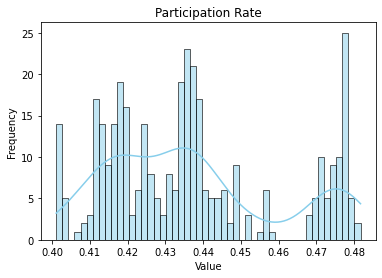

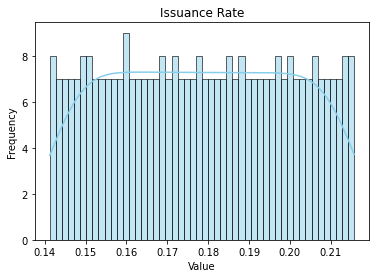

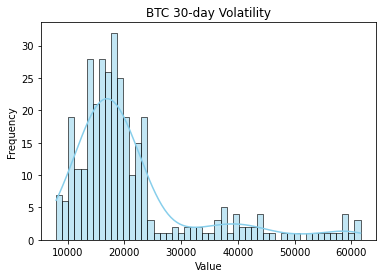

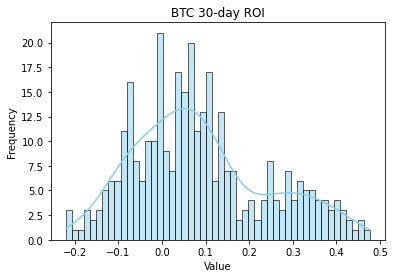

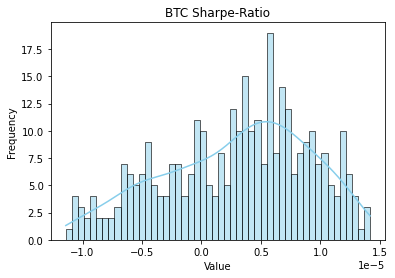

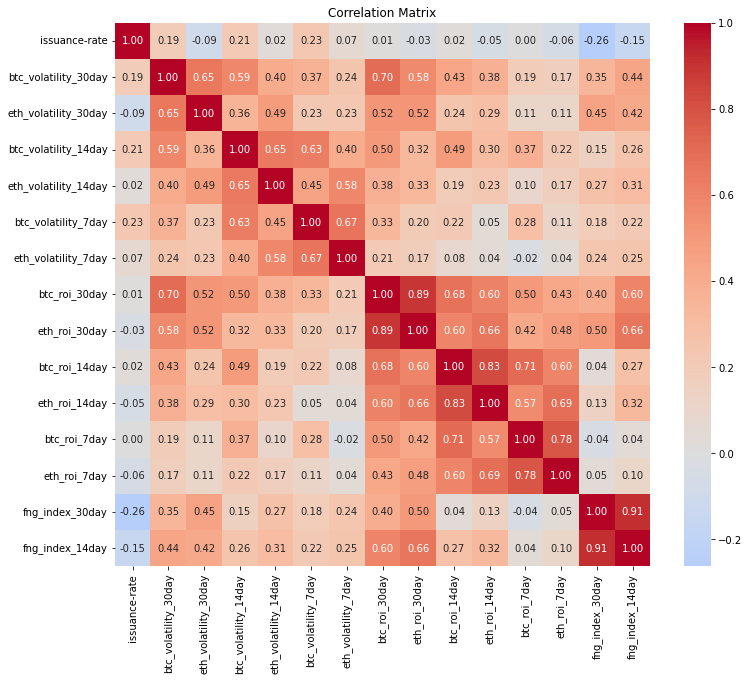

Pearson correlation coefficient: 0.5711
P-value between btc_roi and fng_index: 8.3684e-28
Pearson correlation coefficient: 0.3965
P-value between eth_volatility and fng_index: 6.3626e-13
Pearson correlation coefficient: -0.0200
P-value between btc_roi_7day and fng_index: 7.2771e-01

 Logarithmic OLS (ETH PRICE): 

                            OLS Regression Results                            
Dep. Variable:     participation-rate   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     10.57
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           2.37e-16
Time:                        21:41:21   Log-Likelihood:                 502.60
No. Observations:                 305   AIC:                            -981.2
Df Residuals:                     293   BIC:                            -936.6
Df Model:                          11               

/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_86233/474109767.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors='coerce')
/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_86233/474109767.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target] = pd.to_numeric(data[target], errors='coerce')
/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_86233/474109767.py:405: SettingWithCopyWarning: 
A value is trying to be set on a


 final model 

                            OLS Regression Results                            
Dep. Variable:     participation-rate   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     21.40
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           1.52e-15
Time:                        21:41:21   Log-Likelihood:                 489.91
No. Observations:                 305   AIC:                            -969.8
Df Residuals:                     300   BIC:                            -951.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const           

/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_86233/474109767.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors='coerce')
/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_86233/474109767.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target] = pd.to_numeric(data[target], errors='coerce')
/var/folders/qx/7cv9dlmn5rq3h0j72315bwfr0000gn/T/ipykernel_86233/474109767.py:405: SettingWithCopyWarning: 
A value is trying to be set on a

                               OLS Regression Results                              
Dep. Variable:     participation-rate-diff   R-squared:                       0.190
Model:                                 OLS   Adj. R-squared:                  0.070
Method:                      Least Squares   F-statistic:                     1.579
Date:                     Wed, 13 Aug 2025   Prob (F-statistic):             0.0204
Time:                             21:41:21   Log-Likelihood:                 1325.4
No. Observations:                      303   AIC:                            -2571.
Df Residuals:                          263   BIC:                            -2422.
Df Model:                               39                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [159]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pymc as pm
import arviz as az

from sklearn.linear_model import LassoCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from scipy.stats import pearsonr



def gather_data():
    # Open and read the JSON file
    with open('/Users/saadinurazisbekuulu/Downloads/ShtukaResearch/lpt-data/lpt-data.json', 'r') as file:
        data = json.load(file)

    # Now `data` is a Python dictionary (or list, depending on the JSON structure)
    data = pd.DataFrame(data)
    #print(data['bonded']/data['total-supply']) # participation rate
    #print(data['inflation']/1e9 * data['total-supply']) # new minted tokens
    #print(data['inflation']/1e9 * 365) # annual issuance rate
    data['participation-rate'] = data['bonded']/data['total-supply']
    data['issuance-rate'] = data['inflation']/1e9 * 365
    
    dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
    data['date'] = pd.to_datetime(dates)
    
    df_prices = pd.read_csv('/Users/saadinurazisbekuulu/Downloads/ShtukaResearch/crypto_2024_prices_volumes.csv')
    #print(df_prices.head())
    df_fng = pd.read_csv('/Users/saadinurazisbekuulu/Downloads/ShtukaResearch/dataset_with_sentiment_yield_2024.csv')
    
    # Before any merges, normalize all your `date` columns:
    for df in (data, df_prices, df_fng):    # add every DataFrame you plan to merge
        df['date'] = pd.to_datetime(df['date']).dt.date
    
    # Inner join on 'date'
    df = pd.merge(data, df_prices, on='date', how='inner')
    df['fear-greed-index'] = df_fng['fear_greed_index']

    # Inspect
    #print(df.head(), df.shape)
    df.to_csv('DATA.csv', index=False)
    return df


def price_actions(data):
    from statsmodels.tsa.stattools import adfuller
    
    df = {}
    df['btc_roi'] = data['btc_price_usd']/data['btc_price_usd'].shift(1) - 1
    df['eth_roi'] = data['eth_price_usd']/data['eth_price_usd'].shift(1) - 1
    df['lpt_roi'] = data['lpt_price_usd']/data['lpt_price_usd'].shift(1) - 1
        
    df['participation-rate'] = data['participation-rate']
    df['issuance-rate'] = data['issuance-rate']
    df['participation-rate-diff'] = data['participation-rate'] - data['participation-rate'].shift(1)
    df['issuance-rate-diff'] = data['issuance-rate'] - data['issuance-rate'].shift(1)
    
    df['fng_index'] = data['fear-greed-index']
    df['btc_volume'] = data['btc_volume']
    df['eth_volume'] = data['eth_volume']
    df['lpt_volume'] = data['lpt_volume']
    
    # Example for participation rate
    adf_result_participation = adfuller(df['participation-rate'].iloc[1:])
    print('ADF Statistic:', adf_result_participation[0])
    print('p-value:', adf_result_participation[1])

    # Repeat for issuance rate
    adf_result_issuance = adfuller(df['issuance-rate'].iloc[1:])
    print('ADF Statistic:', adf_result_issuance[0])
    print('p-value:', adf_result_issuance[1])
    
    # COintegration test: difference needed or not
    from statsmodels.tsa.stattools import coint

    score, pvalue, _ = coint(df['participation-rate'], df['issuance-rate'])
    print(f"p-value: {pvalue}, score: {score}")
    
    
    df_data = pd.DataFrame(df)
    
    df_data['btc_roi_30day'] = df['btc_roi'].rolling(window=30).mean() * 30
    df_data['eth_roi_30day'] = df['eth_roi'].rolling(window=30).mean() * 30
    df_data['lpt_roi_30day'] = df['lpt_roi'].rolling(window=30).mean() * 30
    
    df_data['btc_roi_14day'] = df['btc_roi'].rolling(window=14).mean() * 14
    df_data['eth_roi_14day'] = df['eth_roi'].rolling(window=14).mean() * 14
    df_data['lpt_roi_14day'] = df['lpt_roi'].rolling(window=14).mean() * 14
    
    df_data['btc_roi_7day'] = df['btc_roi'].rolling(window=7).mean() * 7
    df_data['eth_roi_7day'] = df['eth_roi'].rolling(window=7).mean() * 7
    df_data['lpt_roi_7day'] = df['lpt_roi'].rolling(window=7).mean() * 7
    
    df_data['btc_volatility_30day'] = data['btc_price_usd'].rolling(window=30).std() * np.sqrt(30)
    df_data['eth_volatility_30day'] = data['eth_price_usd'].rolling(window=30).std() * np.sqrt(30)
    df_data['lpt_volatility_30day'] = data['lpt_price_usd'].rolling(window=30).std() * np.sqrt(30)
    
    df_data['btc_volatility_14day'] = data['btc_price_usd'].rolling(window=14).std() * np.sqrt(14)
    df_data['eth_volatility_14day'] = data['eth_price_usd'].rolling(window=14).std() * np.sqrt(14)
    df_data['lpt_volatility_14day'] = data['lpt_price_usd'].rolling(window=14).std() * np.sqrt(14)
    
    df_data['btc_volatility_7day'] = data['btc_price_usd'].rolling(window=7).std() * np.sqrt(7)
    df_data['eth_volatility_7day'] = data['eth_price_usd'].rolling(window=7).std() * np.sqrt(7)
    df_data['lpt_volatility_7day'] = data['lpt_price_usd'].rolling(window=7).std() * np.sqrt(7)
    
    df_data['btc_sharpe_ratio_7day'] = df_data['btc_roi_7day']/df_data['btc_volatility_7day']
    df_data['btc_sharpe_ratio_14day'] = df_data['btc_roi_14day']/df_data['btc_volatility_14day']
    df_data['btc_sharpe_ratio_30day'] = df_data['btc_roi_30day']/df_data['btc_volatility_30day']

    df_data['eth_sharpe_ratio_30day'] = df_data['eth_roi_30day']/df_data['eth_volatility_30day']
    
    df_data['fng_index_7day'] = df['fng_index'].rolling(window=7).mean()
    df_data['fng_index_14day'] = df['fng_index'].rolling(window=14).mean()
    df_data['fng_index_30day'] = df['fng_index'].rolling(window=30).mean()
    
    #downside_returns = df[df['btc_price_usd'] < 0]
    #downside_std = downside_returns.std() * np.sqrt(365)

    
    
    sns.histplot(df_data['participation-rate'], kde=True, bins=50, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Participation Rate')
    plt.show()
    
    sns.histplot(df_data['issuance-rate'], kde=True, bins=50, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Issuance Rate')
    plt.show()
    
    sns.histplot(df_data['btc_volatility_30day'], kde=True, bins=50, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('BTC 30-day Volatility')
    plt.show()
    
    sns.histplot(df_data['btc_roi_30day'], kde=True, bins=50, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('BTC 30-day ROI')
    plt.show()
    
    sns.histplot(df_data['btc_sharpe_ratio_30day'], kde=True, bins=50, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('BTC Sharpe-Ratio')
    plt.show()
        
    return df_data
    
def _fit_aicbic(y, X, criterion="AIC"):
    """Fit OLS with intercept and return (criterion_value, model)."""
    Xc = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, Xc).fit()
    if criterion.upper() == "AIC":
        score = model.aic
    elif criterion.upper() == "BIC":
        score = model.bic
    else:
        raise ValueError("criterion must be 'AIC' or 'BIC'")
    return score, model

def stepwise_select(
    X: pd.DataFrame,
    y: pd.Series,
    direction: str = "both",         # "forward" | "backward" | "both"
    criterion: str = "AIC",          # "AIC" | "BIC"
    verbose: bool = True,
):
    """
    Stepwise selection using AIC/BIC. Returns (selected_columns, fitted_model, trace_df).
    X: predictors (DataFrame), y: target (Series).
    Drops rows with missing values in selected columns on each fit.
    """
    criterion = criterion.upper()
    direction = direction.lower()
    all_candidates = list(X.columns)
    selected: list[str] = []
    current_score = np.inf
    trace = []

    def log(action, cols, score):
        trace.append({"action": action, "k": len(cols), "score": score, "features": cols.copy()})

    improved = True
    while improved:
        improved = False

        # FORWARD STEP
        if direction in ("forward", "both"):
            remaining = [c for c in all_candidates if c not in selected]
            best_score, best_var, best_model = None, None, None

            for c in remaining:
                cols = selected + [c]
                Xi = X[cols]
                df_fit = pd.concat([y, Xi], axis=1).dropna()
                if df_fit.empty:
                    continue
                try:
                    score, model = _fit_aicbic(df_fit[y.name], df_fit[cols], criterion)
                except Exception:
                    continue
                if best_score is None or score < best_score:
                    best_score, best_var, best_model = score, c, model

            if best_score is not None and best_score + 1e-8 < current_score:
                selected.append(best_var)
                current_score = best_score
                final_model = best_model
                improved = True
                if verbose:
                    log(f"add {best_var}", selected, current_score)


        # BACKWARD STEP
        if direction in ("backward", "both") and selected:
            best_score, worst_var, best_model = current_score, None, None
            for c in list(selected):
                trial = [v for v in selected if v != c]
                if not trial:
                    continue
                Xi = X[trial]
                df_fit = pd.concat([y, Xi], axis=1).dropna()
                if df_fit.empty:
                    continue
                try:
                    score, model = _fit_aicbic(df_fit[y.name], df_fit[trial], criterion)
                except Exception:
                    continue
                if score + 1e-8 < best_score:
                    best_score, worst_var, best_model = score, c, model

            if worst_var is not None:
                selected.remove(worst_var)
                current_score = best_score
                final_model = best_model
                improved = True
                if verbose:
                    log(f"drop {worst_var}", selected, current_score)

    # Final fit on selected
    if selected:
        df_fit = pd.concat([y, X[selected]], axis=1).dropna()
        _, final_model = _fit_aicbic(df_fit[y.name], df_fit[selected], criterion)
    else:
        # Intercept-only model
        df_fit = y.dropna()
        final_model = sm.OLS(df_fit, sm.add_constant(pd.DataFrame(index=df_fit.index))).fit()

    trace_df = pd.DataFrame(trace)
    return selected, final_model, trace_df

    
def OLS(data, features, target = 'participation-rate-diff'):
    # Manipulate data
    data['fng_index'] = data['fng_index'] - data['fng_index'].shift(1)
    data['btc_volatility_7day'] = data['btc_volatility_7day'] - data['btc_volatility_7day'].shift(1)
    data['eth_volatility_7day'] = data['eth_volatility_7day'] - data['eth_volatility_7day'].shift(1)
    data['lpt_volatility_7day'] = data['lpt_volatility_7day'] - data['lpt_volatility_7day'].shift(1)
    data['btc_volatility_14day'] = data['btc_volatility_14day'] - data['btc_volatility_14day'].shift(1)
    data['eth_volatility_14day'] = data['eth_volatility_14day'] - data['eth_volatility_14day'].shift(1)
    data['lpt_volatility_14day'] = data['lpt_volatility_14day'] - data['lpt_volatility_14day'].shift(1)
    data['btc_volatility_30day'] = data['btc_volatility_30day'] - data['btc_volatility_30day'].shift(1)
    data['eth_volatility_30day'] = data['eth_volatility_30day'] - data['eth_volatility_30day'].shift(1)
    data['lpt_volatility_30day'] = data['lpt_volatility_30day'] - data['lpt_volatility_30day'].shift(1)
    
    # Create Lagged Variables
    data['btc_roi_7day_lag1'] = data['btc_roi_7day'].shift(1)
    data['btc_roi_7day_lag2'] = data['btc_roi_7day'].shift(2)
    data['btc_roi_7day_lag3'] = data['btc_roi_7day'].shift(3)
    data['btc_roi_7day_lag4'] = data['btc_roi_7day'].shift(4)
    data['btc_roi_7day_lag5'] = data['btc_roi_7day'].shift(5)
    data['btc_roi_7day_lag6'] = data['btc_roi_7day'].shift(6)
    
    data['eth_roi_7day_lag1'] = data['eth_roi_7day'].shift(1)
    data['eth_roi_7day_lag2'] = data['eth_roi_7day'].shift(2)
    data['eth_roi_7day_lag3'] = data['eth_roi_7day'].shift(3)
    data['eth_roi_7day_lag4'] = data['eth_roi_7day'].shift(4)
    data['eth_roi_7day_lag5'] = data['eth_roi_7day'].shift(5)
    data['eth_roi_7day_lag6'] = data['eth_roi_7day'].shift(6)
    
    data['lpt_roi_7day_lag1'] = data['lpt_roi_7day'].shift(1)
    data['lpt_roi_7day_lag2'] = data['lpt_roi_7day'].shift(2)
    data['lpt_roi_7day_lag3'] = data['lpt_roi_7day'].shift(3)
    data['lpt_roi_7day_lag4'] = data['lpt_roi_7day'].shift(4)
    data['lpt_roi_7day_lag5'] = data['lpt_roi_7day'].shift(5)
    data['lpt_roi_7day_lag6'] = data['lpt_roi_7day'].shift(6)
    
    # Prepare data
    data = data.dropna()
    
    # Ensure all inputs are numeric
    for col in features:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data['participation-rate-diff'] = pd.to_numeric(data['participation-rate-diff'], errors='coerce')
    
    X = data[features]
    y = data[target]
    
    # Standardize
    X = (X - X.mean())/X.std()
    #y = (y - y.mean())/y.std()
    
    X_const = sm.add_constant(X)

    # 6. Fit the OLS regression model
    ols_model = sm.OLS(y, X_const).fit()

    # 7. Print the full statistical summary
    print(ols_model.summary())
    
    
    '''def stepwise_selection(X, y, criterion='aic'):
        included = []
        best_score = float('inf')

        while True:
            changed = False
            excluded = list(set(X.columns) - set(included))
            new_scores = []

            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
                score = model.aic if criterion == 'aic' else model.bic
                new_scores.append((score, new_column))

            if new_scores:
                best_new_score, best_candidate = min(new_scores)
                if best_new_score < best_score:
                    included.append(best_candidate)
                    best_score = best_new_score
                    changed = True

            if not changed:
                break

        return included'''
    
    
    # Example usage:
    # X = your DataFrame of predictors
    # y = your target variable
    selected, model, trace = stepwise_select(X, y, direction="both", criterion="AIC", verbose=True)

    #selected_features = stepwise_selection(X, y, criterion='aic')
    final_model = sm.OLS(y, sm.add_constant(X[selected])).fit()
    print(final_model.summary())
    
    return ols_model, final_model
    
def Logarithmic_OLS(data, features, target):
    # Create Lagged Variables
    data['btc_roi_7day_lag1'] = data['btc_roi_7day'].shift(1)
    data['btc_roi_7day_lag2'] = data['btc_roi_7day'].shift(2)
    data['btc_roi_7day_lag3'] = data['btc_roi_7day'].shift(3)
    data['btc_roi_7day_lag4'] = data['btc_roi_7day'].shift(4)
    data['btc_roi_7day_lag5'] = data['btc_roi_7day'].shift(5)
    data['btc_roi_7day_lag6'] = data['btc_roi_7day'].shift(6)
    
    data['eth_roi_7day_lag1'] = data['eth_roi_7day'].shift(1)
    data['eth_roi_7day_lag2'] = data['eth_roi_7day'].shift(2)
    data['eth_roi_7day_lag3'] = data['eth_roi_7day'].shift(3)
    data['eth_roi_7day_lag4'] = data['eth_roi_7day'].shift(4)
    data['eth_roi_7day_lag5'] = data['eth_roi_7day'].shift(5)
    data['eth_roi_7day_lag6'] = data['eth_roi_7day'].shift(6)
    
    data['lpt_roi_7day_lag1'] = data['lpt_roi_7day'].shift(1)
    data['lpt_roi_7day_lag2'] = data['lpt_roi_7day'].shift(2)
    data['lpt_roi_7day_lag3'] = data['lpt_roi_7day'].shift(3)
    data['lpt_roi_7day_lag4'] = data['lpt_roi_7day'].shift(4)
    data['lpt_roi_7day_lag5'] = data['lpt_roi_7day'].shift(5)
    data['lpt_roi_7day_lag6'] = data['lpt_roi_7day'].shift(6)
    
    data = data.dropna()
    '''features = ['issuance-rate', 
               'btc_volatility_30day',
               'eth_volatility_30day',
               'lpt_volatility_30day',
               'eth_price_30day',
               'fng_index',
               'btc_volume',
               'eth_volume']'''
    
    # Ensure all inputs are numeric
    for col in features:
        data[col] = pd.to_numeric(data[col], errors='coerce')    
    data[target] = pd.to_numeric(data[target], errors='coerce')
    
    
    # Loop through matching columns and apply transformation
    substring = 'roi'
    for col in data.columns:
        if substring in col:
            data[col] = data[col] + 1  # Example manipulation
    substring = 'sharpe'
    for col in data.columns:
        if substring in col:
            data[col] = data[col] + 1  # Example manipulation

    
    X = np.log(data[features])
    y = np.log(data[target])
    
    # standardize
    X_scaled = (X - X.mean())/X.std() 
    
    # Wrap back into DataFrame with original column names    
    X_const = sm.add_constant(X_scaled)

    # 6. Fit the OLS regression model
    ols_model = sm.OLS(y, X_const).fit()

    # 7. Print the full statistical summary
    print(ols_model.summary())
    
    # Example usage:
    # X = your DataFrame of predictors
    # y = your target variable
    initial_model = sm.OLS(y, sm.add_constant(X[['issuance-rate']])).fit()
    print("\n Initial Model \n")
    print(initial_model.summary())

    
    selected_features, model, trace = stepwise_select(X_scaled, y, direction="both", criterion="AIC", verbose=True)
    final_model = sm.OLS(y, sm.add_constant(X_scaled[selected_features])).fit()
    print('\n final model \n')
    print(final_model.summary())
    
    
    '''# Get p-values
    p_values = ols_model.pvalues
    significant_vars = p_values[p_values < 0.05].index.tolist()

    # Remove constant if present
    significant_vars = [var for var in significant_vars if var != 'const']

    # Calculate VIF for significant variables
    vif_data = pd.DataFrame()
    vif_data['feature'] = significant_vars
    vif_data['VIF'] = [variance_inflation_factor(X[significant_vars].values, i) for i in range(len(significant_vars))]

    # Filter out variables with high multicollinearity (VIF > 10)
    robust_vars = vif_data[vif_data['VIF'] < 10]['feature'].tolist()
    print(vif_data)

    # Apply LassoCV for regularization-based feature selection
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[robust_vars])

    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected = [robust_vars[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

    # Final selected features
    print("Statistically significant variables (p < 0.05):", significant_vars)
    print("Variables with low multicollinearity (VIF < 10):", robust_vars)
    print("Variables selected by LassoCV:", lasso_selected)
    
    final_model = sm.OLS(y, sm.add_constant(X[lasso_selected])).fit()
    print('\n final model \n')
    print(final_model.summary())'''
    return initial_model, final_model

    
def PCA_analysis(data, features):
    data = data[features]
    df = data.dropna()
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Determine number of components to explain at least 95% variance
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"Number of components required to explain at least 95% variance: {n_components_95}")
    
    
    # Get PCA components (loadings)
    loadings = pd.DataFrame(pca.components_[:n_components_95], columns=df.columns)

    # Identify top contributing variables for each component
    top_contributors = {}
    for i in range(n_components_95):
        component_loadings = loadings.iloc[i]
        top_features = component_loadings.abs().sort_values(ascending=False).head(5).index.tolist()
        top_contributors[f'PC{i+1}'] = top_features

    # Display the top contributing variables for each component
    for pc, features in top_contributors.items():
        print(f"{pc}: {features}")


    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
    plt.axvline(x=n_components_95 - 1, color='g', linestyle='--', label=f'{n_components_95} Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return top_contributors

    
def BayesianModel(data, features):
    df_model = data.dropna()
    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_model[features])
    y_scaled = scaler.fit_transform(df_model[['participation-rate']].values).flatten()

    # Bayesian model
    with pm.Model() as model:
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        beta = pm.Normal('beta_btc_roi', mu=[1,-1,-1], sigma=1, shape=3)
        sigma = pm.HalfNormal('sigma', sigma=1)

        #mu = intercept + beta * X_scaled.flatten()
        mu = intercept + pm.math.dot(X_scaled, beta)

        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_scaled)

        trace = pm.sample(1000, tune=1000, target_accept=0.9)

    # Summarize
    summary = az.summary(trace, round_to=2)
    print(summary)

    # Plot posterior
    az.plot_posterior(trace)
    
    return summary
    

data = gather_data()    
data_new = price_actions(data)
data_new.to_csv('DATA_simulation.csv', index=False)

# Compute correlation matrix
corr_matrix = data_new[['issuance-rate', 'btc_volatility_30day', 'eth_volatility_30day', 
                          'btc_volatility_14day', 'eth_volatility_14day', 'btc_volatility_7day',
                          'eth_volatility_7day', 'btc_roi_30day', 'eth_roi_30day', 'btc_roi_14day',
                          'eth_roi_14day', 'btc_roi_7day', 'eth_roi_7day', 'fng_index_30day', 'fng_index_14day'
                         ]].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.savefig("Corr_Matrix.pdf", bbox_inches="tight")
plt.show()

# Calculate Pearson correlation and p-value
corr_coef, p_value = pearsonr(data_new.dropna()['btc_roi_30day'], data_new.dropna()['fng_index_14day'])

print(f"Pearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value between btc_roi and fng_index: {p_value:.4e}")


# Calculate Pearson correlation and p-value
corr_coef, p_value = pearsonr(data_new.dropna()['eth_volatility_30day'], data_new.dropna()['fng_index_14day'])

print(f"Pearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value between eth_volatility and fng_index: {p_value:.4e}")

# Calculate Pearson correlation and p-value
corr_coef, p_value = pearsonr(data_new.dropna()['btc_roi_7day'], data_new.dropna()['fng_index_14day'])

print(f"Pearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value between btc_roi_7day and fng_index: {p_value:.4e}")


print('\n Logarithmic OLS (ETH PRICE): \n')
initial_summary, eth_ols_summary = Logarithmic_OLS(data_new, features = ['issuance-rate', 'eth_volatility_7day',
                                                                         'eth_volatility_14day','eth_volatility_30day',
                                                                        'eth_roi_7day', 'eth_roi_7day_lag1',
                                                                        'eth_roi_7day_lag2', 'eth_roi_7day_lag3',
                                                                        'eth_roi_7day_lag4', 'eth_roi_7day_lag5',
                                                                        'eth_roi_7day_lag6'],
                                                  target = 'participation-rate')

print('\n Logarithmic OLS (BTC PRICE): \n')
initial_summary, btc_ols_summary = Logarithmic_OLS(data_new, features = ['issuance-rate', 'btc_volatility_7day', 
                                                                         'btc_volatility_30day', 'btc_roi_7day',
                                                                        'btc_roi_7day_lag1', 'btc_roi_7day_lag2',
                                                                        'btc_roi_7day_lag3', 'btc_roi_7day_lag4',
                                                                        'btc_roi_7day_lag5', 'btc_roi_7day_lag6'],
                                                  target = 'participation-rate')

initial_summary_html = initial_summary.summary().as_html()
btc_summary_log = btc_ols_summary.summary().as_html()
eth_summary_log = eth_ols_summary.summary().as_html()

with open("initial_summary.html", "w") as f:
    f.write(initial_summary_html)
with open("btc_summary_log.html", "w") as f:
    f.write(btc_summary_log)
with open("eth_summary_log.html", "w") as f:
    f.write(eth_summary_log)



'''print('\n Logarithmic OLS (Overall): \n')
results = Logarithmic_OLS(data_new, features = ['issuance-rate', 'btc_volatility_30day', 'eth_volatility_30day', 
                                      'btc_volatility_14day', 'eth_volatility_14day', 'btc_volatility_7day',
                                      'eth_volatility_7day', 'btc_roi_30day', 'eth_roi_30day', 'btc_roi_14day',
                                      'eth_roi_14day', 'btc_roi_7day', 'eth_roi_7day', 'fng_index_30day', 'fng_index_14day'
                                     ])

summary_overall_html = results.summary().as_html()

with open("summary_overall.html", "w") as f:
    f.write(summary_overall_html)'''

print('\n Logarithmic OLS (Least Correlated): \n')
inital, results = Logarithmic_OLS(data_new, features = ['issuance-rate', 'btc_roi_14day', 
                                                        'eth_volatility_14day', 'fng_index_30day'
                                     ], target = 'participation-rate')

least_corr_log = results.summary().as_html()
with open("least_corr_log.html", "w") as f:
    f.write(least_corr_log)

print('\n Logarithmic OLS (Least Correlated Part 2): \n')
initial, results = Logarithmic_OLS(data_new, features = ['issuance-rate', 'fng_index_30day'],
                                  target='participation-rate')

fng_log = results.summary().as_html()
with open("fng_log.html", "w") as f:
    f.write(fng_log)

print('\n Linear OLS: \n')
initial, results = OLS(data_new, features = ['issuance-rate-diff'])

initial_html = initial.summary().as_html()
with open("baseline_linear.html", "w") as f:
    f.write(initial_html)

print('\n Linear OLS 2: \n')
initial, results = OLS(data_new, features = ['issuance-rate-diff', 'btc_roi_14day', 
                                    'eth_volatility_14day', 'fng_index_30day'])

initial_html = initial.summary().as_html()
summary_html = results.summary().as_html()
with open("summary_linear_initial.html", "w") as f:
    f.write(initial_html)
with open("summary_linear_best.html", "w") as f:
    f.write(summary_html)
    
print('\n Linear OLS Overall: \n')
results = OLS(data_new, features = ['issuance-rate-diff', 'eth_roi_7day', 'eth_roi_7day_lag1',
                                   'eth_roi_7day_lag2', 'eth_roi_7day_lag3', 'eth_roi_7day_lag4',
                                   'eth_roi_7day_lag5', 'eth_volatility_14day',
                                   'lpt_roi_7day', 'lpt_roi_7day_lag1', 'lpt_roi_7day_lag1',
                                   'lpt_roi_7day_lag2', 'lpt_roi_7day_lag3', 'lpt_roi_7day_lag4',
                                   'lpt_roi_7day_lag5', 'lpt_volatility_14day',
                                   'btc_roi_7day', 'btc_roi_7day_lag1', 'btc_roi_7day_lag2',
                                   'btc_roi_7day_lag3', 'btc_roi_7day_lag4', 'btc_roi_7day_lag5',
                                   'btc_volatility_14day', 'eth_volatility_30day', 'btc_volatility_30day',
                                   'btc_volatility_7day', 'eth_volatility_7day', 'lpt_volatility_7day',
                                   'btc_roi_14day', 'eth_roi_14day', 'lpt_roi_14day', 
                                   'btc_roi_30day', 'eth_roi_30day', 'lpt_roi_30day',
                                   'fng_index_14day', 'fng_index_30day', 'fng_index_7day',
                                   'btc_sharpe_ratio_7day', 'btc_sharpe_ratio_14day', 'btc_sharpe_ratio_30day'])


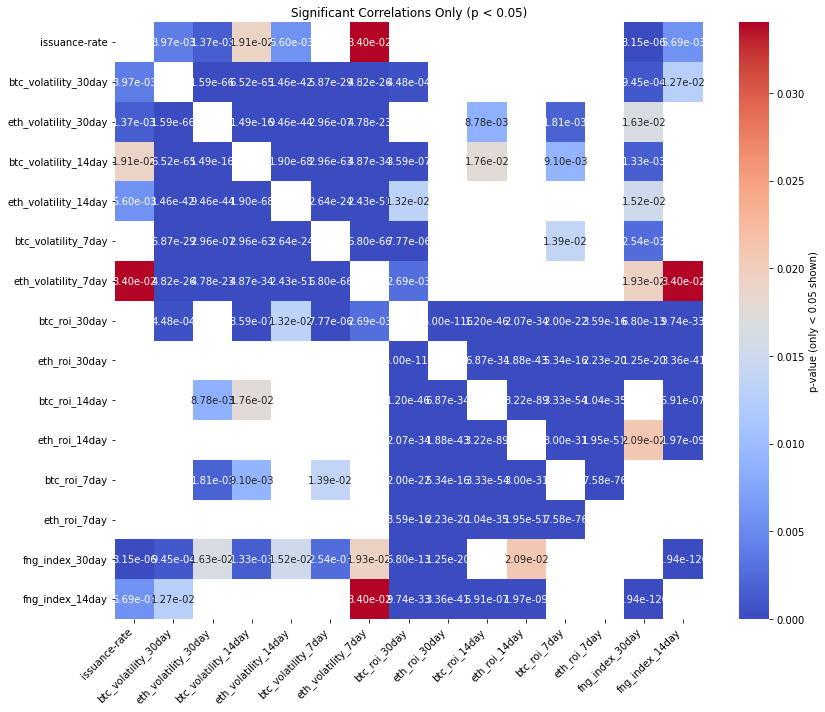

                      issuance-rate  btc_volatility_30day  \
issuance-rate                  0.00                 -0.16   
btc_volatility_30day          -0.16                  0.00   
eth_volatility_30day           0.17                  0.77   
btc_volatility_14day          -0.13                  0.76   
eth_volatility_14day           0.15                  0.66   
btc_volatility_7day           -0.09                  0.56   
eth_volatility_7day            0.11                  0.53   
btc_roi_30day                  0.01                  0.19   
eth_roi_30day                 -0.03                  0.00   
btc_roi_14day                  0.02                  0.02   
eth_roi_14day                 -0.05                 -0.05   
btc_roi_7day                   0.00                 -0.02   
eth_roi_7day                  -0.06                 -0.05   
fng_index_30day               -0.26                  0.19   
fng_index_14day               -0.15                  0.14   

                      e

In [106]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

def pairwise_pearson_significance(df, alpha=0.05):
    """
    Compute pairwise Pearson correlation and p-values for all columns in df.

    Returns:
    - corr_matrix: DataFrame of correlation coefficients
    - pval_matrix: DataFrame of p-values
    - significant_pairs: List of (var1, var2, r, p) for p < alpha
    """
    cols = df.columns
    n = len(cols)
    
    corr_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
    pval_matrix = pd.DataFrame(np.ones((n, n)), columns=cols, index=cols)
    significant_pairs = []
    non_significant_pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            col1 = cols[i]
            col2 = cols[j]
            x = df[col1]
            y = df[col2]
            
            # Drop NA pairs
            mask = x.notna() & y.notna()
            if mask.sum() < 3:  # not enough data
                continue
            r, p = pearsonr(x[mask], y[mask])
            corr_matrix.loc[col1, col2] = corr_matrix.loc[col2, col1] = r
            pval_matrix.loc[col1, col2] = pval_matrix.loc[col2, col1] = p
            if p < alpha:
                significant_pairs.append((col1, col2, r, p))
            else:
                non_significant_pairs.append((col1, col2, r, p))
                
    mask = pval_matrix > 0.05

    plt.figure(figsize=(12, 10))
    sns.heatmap(pval_matrix, annot=True, fmt=".2e", cmap="coolwarm",
                mask=mask, cbar_kws={'label': 'p-value (only < 0.05 shown)'})
    plt.title("Significant Correlations Only (p < 0.05)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix, pval_matrix, non_significant_pairs


# Assume df is your DataFrame
corr, pvals, sig = pairwise_pearson_significance(data_new[['issuance-rate', 'btc_volatility_30day', 'eth_volatility_30day', 
                          'btc_volatility_14day', 'eth_volatility_14day', 'btc_volatility_7day',
                          'eth_volatility_7day', 'btc_roi_30day', 'eth_roi_30day', 'btc_roi_14day',
                          'eth_roi_14day', 'btc_roi_7day', 'eth_roi_7day', 'fng_index_30day', 'fng_index_14day'
                         ]])

# View correlation matrix
print(corr.round(2))

# View significant pairs only
sig_df = pd.DataFrame(sig, columns=['Variable 1', 'Variable 2', 'Correlation r', 'p-value'])
print(sig_df.sort_values(by='p-value'))


In [ ]:

BayesianModel(data_new)